# Instrumental variables: Testing assumptions

How biased are the results if we violate the assumptions?

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widget

C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# enable graphs
%matplotlib inline

## Data

In [4]:
df = pd.DataFrame()
#salary = education + iq + rest_1
#education = birthmonth + iq + rest_2

n = 10000
anti_corr = 1
df['iq'] = np.random.normal(100, 10, size=n)
df['birth_month'] = np.random.uniform(1, 12, size=n)
df['education'] = (0.1 * df.iq) + (0.001 *df.birth_month) + (anti_corr * np.random.normal(0, 1, size=n) )
df['salary'] = df.education + df.iq

df.assign('salary = education + iq')

df.corr()


TypeError: assign() takes 1 positional argument but 2 were given

In [6]:
df = pd.DataFrame()
#salary = education + iq + rest_1
#education = birthmonth + iq + rest_2

n = 10000
anti_corr = 1
df['iq'] = np.random.normal(size=n)
df['birth'] = np.random.normal(size=n)
df['education'] = df.iq + df.birth + (anti_corr * np.random.normal(size=n)) 
df['education'] = df.birth + (anti_corr * np.random.normal(size=n)) 
df['education'] = df.birth + (anti_corr * np.random.normal(size=n)) 

df['luck'] = np.random.normal(size=n)
df['salary'] = df.education + df.iq + df.luck

#df.assign('salary = education + iq')
df.corr()

,iq,birth,education,luck,salary
iq,1.000000,0.000246,-0.003149,0.004982,0.497144
birth,0.000246,1.000000,0.716294,-0.004843,0.510146
education,-0.003149,0.716294,1.000000,0.001528,0.714527
luck,0.004982,-0.004843,0.001528,1.000000,0.493527
salary,0.497144,0.510146,0.714527,0.493527,1.000000


In [31]:
#%% basic descriptive
df.head()

,iq,birth_month,education,salary
0,0.159660,0.846030,-0.095563,0.064097
1,-0.840566,0.812360,-0.400807,-1.241374
2,-0.915778,0.340665,0.073298,-0.842480
3,-0.527123,0.750139,-0.438991,-0.966114
4,1.052601,0.409329,1.680005,2.732606


In [7]:
name= "https://github.com/hmelberg/causal/blob/master/data/iv_voucher_data.dta"

In [14]:
df = pd.read_stata("C:/Users/hmelberg_adm/Documents/GitHub/causal/data/iv_voucher_data.dta")

In [15]:
df.to_csv('C:/Users/hmelberg_adm/Documents/iv_voucher_data.csv')

In [22]:
df.corr()

,iq,birth_month,education
iq,1.000000,0.005196,0.045975
birth_month,0.005196,1.000000,-0.015272
education,0.045975,-0.015272,1.000000


In [23]:
df.columns

Index(['iq', 'birth_month', 'education'], dtype='object')

In [24]:
df.dtypes

iq             float64
birth_month    float64
education      float64
dtype: object

In [6]:
df.describe()

,id,won_lottry,male,base_age,finish8th,use_fin_aid
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,1357.010248,0.505551,0.504697,12.004270,0.681469,0.581554
std,890.711584,0.500183,0.500192,1.347038,0.466106,0.493515
min,3.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,616.000000,0.000000,0.000000,11.000000,0.000000,0.000000
50%,1280.000000,1.000000,1.000000,12.000000,1.000000,1.000000
75%,1982.500000,1.000000,1.000000,13.000000,1.000000,1.000000
max,4030.000000,1.000000,1.000000,17.000000,1.000000,1.000000


# Basic (Naive) analysis

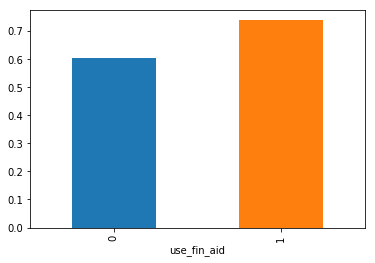

In [7]:
#%% basic and naive canalysis, comparing averages: did financial aid help?

# plot avarage comparing those who received financial aid and those who did not
df.groupby('use_fin_aid')['finish8th'].mean().plot(kind = 'bar');

In [9]:
# calculate the absolute and precentage differences

df.groupby('use_fin_aid')['finish8th'].mean().diff()

use_fin_aid
0        NaN
1    0.13307
Name: finish8th, dtype: float64

In [10]:
df.groupby('use_fin_aid')['finish8th'].mean().pct_change()

use_fin_aid
0         NaN
1    0.220284
Name: finish8th, dtype: float64

In [11]:
#%% ordinary regression

model = "finish8th ~ use_fin_aid + male + base_age"

ols_results = sm.formula.logit(model, data = df).fit()

ols_results.summary()

Optimization terminated successfully.
         Current function value: 0.593505
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              finish8th   No. Observations:                 1171
Model:                          Logit   Df Residuals:                     1167
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Oct 2018   Pseudo R-squ.:                 0.05154
Time:                        02:19:57   Log-Likelihood:                -694.99
converged:                       True   LL-Null:                       -732.76
                                        LLR p-value:                 2.784e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.2496      0.596      7.128      0.000       3.081       5.418
use_fin_aid     0.5773      0.130      4.441      0.000       0.323       0.832
male           -0.4192      0.130     -3.216      0.001      -0.675      -0.164
base_age       -0.2967      0.048     -6.156      0.000      -0.391      -0.202
===============================================================================
"""

In [ ]:
#%% Instrumental variables: Use "won lottry" as an instrument

# Is there a correlation?

In [16]:
df[['won_lottry', 'use_fin_aid']].corr()

,won_lottry,use_fin_aid
won_lottry,1.000000,0.684598
use_fin_aid,0.684598,1.000000


In [ ]:
# First step: Model how lottery (instrument) affects financial aid use

In [17]:
stage1_model = "use_fin_aid ~ won_lottry + male + base_age"

stage1_results = sm.formula.logit(stage1_model, data = df).fit()

stage1_results.summary()

Optimization terminated successfully.
         Current function value: 0.416735
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            use_fin_aid   No. Observations:                 1171
Model:                          Logit   Df Residuals:                     1167
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Oct 2018   Pseudo R-squ.:                  0.3870
Time:                        02:24:06   Log-Likelihood:                -488.00
converged:                       True   LL-Null:                       -796.03
                                        LLR p-value:                3.318e-133
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3455      0.731      0.472      0.637      -1.088       1.779
won_lottry     3.5514      0.178     19.934      0.000       3.202       3.901
male          -0.1622      0.164     -0.992      0.321      -0.483       0.158
base_age      -0.1184      0.061     -1.946      0.052      -0.238       0.001
==============================================================================
"""

In [18]:
# create variable with predicted value from the regression

df['predicted_use_fin_aid'] = stage1_results.predict()

In [19]:
# Second step: Predict effect using predicted fin. aid as a variable

stage2_model = "finish8th ~ predicted_use_fin_aid + male + base_age"

iv_results = sm.formula.logit(stage2_model, data = df).fit()

iv_results.summary()

Optimization terminated successfully.
         Current function value: 0.594917
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              finish8th   No. Observations:                 1171
Model:                          Logit   Df Residuals:                     1167
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Oct 2018   Pseudo R-squ.:                 0.04928
Time:                        02:24:43   Log-Likelihood:                -696.65
converged:                       True   LL-Null:                       -732.76
                                        LLR p-value:                 1.423e-15
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.0756      0.604      6.753      0.000       2.893       5.258
predicted_use_fin_aid     0.7743      0.192      4.036      0.000       0.398       1.150
male                     -0.4175      0.130     -3.208      0.001      -0.673      -0.162
base_age                 -0.2919      0.048     -6.077      0.000      -0.386      -0.198
=========================================================================================
"""